### Importing packages

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns


from datetime import datetime

from IPython.core.pylabtools import figsize
from dateutil.relativedelta import relativedelta
from fontTools.subset.svg import xpath

### Defining some parameters

In [7]:
PATH = "stock-samples/MAPNA.csv"
USELESS_COLUMN_NAMES = ["<TICKER>", "<FIRST>", "<HIGH>", "<LOW>", "<VALUE>", "<VOL>", "<OPENINT>", "<PER>", "<OPEN>",
                        "<LAST>"]
DATE_COLUMN_NAME = "<DTYYYYMMDD>"
CLOSE_COLUMN_NAME = "<CLOSE>"
DATA_MAX_AGE = 5  # keep datas that are at most from 5 years ago
MOVING_AVERAGE_PAIRS = [(4, 8), (3, 5), (10, 20), (10, 30)]

### Reading sample data

In [9]:
df = pd.read_csv(PATH, index_col=None)
df.sort_values(by=DATE_COLUMN_NAME, ascending=True, inplace=True, ignore_index=True)
df

,<TICKER>,<DTYYYYMMDD>,<FIRST>,<HIGH>,<LOW>,<CLOSE>,<VALUE>,<VOL>,<OPENINT>,<PER>,<OPEN>,<LAST>
0,MAPNA,20070826,1350.0,1359.0,1350.0,1352.0,591427151280,437402390,10429,D,1350.0,1352.0
1,MAPNA,20070827,1379.0,1379.0,1379.0,1379.0,19347625115,14030185,1887,D,1352.0,1379.0
2,MAPNA,20070828,1406.0,1406.0,1370.0,1403.0,144131253978,102663438,7137,D,1379.0,1403.0
3,MAPNA,20070901,1420.0,1431.0,1407.0,1429.0,26814720068,18758591,1468,D,1403.0,1429.0
4,MAPNA,20070902,1457.0,1457.0,1457.0,1457.0,4749522772,3259796,241,D,1429.0,1457.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3426,MAPNA,20241008,11750.0,11750.0,11750.0,11850.0,14253455000,1213060,62,D,11860.0,11750.0
3427,MAPNA,20241009,11740.0,11740.0,11740.0,11820.0,30183246500,2570975,81,D,11850.0,11740.0
3428,MAPNA,20241012,11470.0,11630.0,11470.0,11470.0,760995635740,66344622,2136,D,11820.0,11470.0
3429,MAPNA,20241013,11290.0,11560.0,11130.0,11200.0,175534736600,15671221,1068,D,11470.0,11130.0


In [34]:
df.tail(50)

,<TICKER>,<DTYYYYMMDD>,<FIRST>,<HIGH>,<LOW>,<CLOSE>,<VALUE>,<VOL>,<OPENINT>,<PER>,<OPEN>,<LAST>
3381,MAPNA,20240724,10640.0,10700.0,10560.0,10590.0,94531535730,8917405,868,D,10570.0,10650.0
3382,MAPNA,20240727,10700.0,11010.0,10620.0,10700.0,110480532860,10316334,1012,D,10590.0,10700.0
3383,MAPNA,20240729,10760.0,10780.0,10410.0,10660.0,51896222170,4894378,861,D,10700.0,10600.0
3384,MAPNA,20240730,10710.0,10730.0,10500.0,10630.0,44553984580,4210668,1231,D,10660.0,10600.0
3385,MAPNA,20240731,10000.0,10190.0,10000.0,10000.0,225146300720,22504947,931,D,10630.0,10000.0
3386,MAPNA,20240803,9650.0,9660.0,9400.0,9450.0,128512928910,13600427,1123,D,10000.0,9400.0
3387,MAPNA,20240804,9360.0,9540.0,9360.0,9420.0,50948276980,5426540,627,D,9450.0,9360.0
3388,MAPNA,20240811,9000.0,9000.0,8840.0,8910.0,27917924250,3149664,348,D,8920.0,8840.0
3389,MAPNA,20240812,8890.0,8890.0,8830.0,8900.0,14301594410,1619647,139,D,8910.0,8830.0
3390,MAPNA,20240813,8820.0,8820.0,8820.0,8860.0,61884745020,7016411,249,D,8900.0,8820.0


### closing - opening price

last 100 days

<BarContainer object of 100 artists>

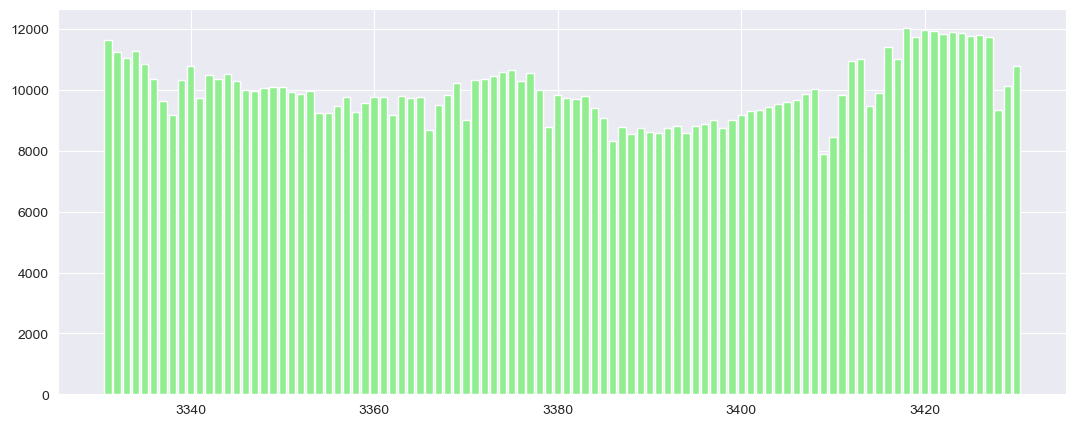

In [31]:
recent_df = df.tail(100)

plt.bar(
    recent_df.index, recent_df["<CLOSE>"] - recent_df["<OPENINT>"],
    color=np.where(recent_df["<CLOSE>"] - recent_df["<OPENINT>"] < 0, 'crimson', 'lightgreen'))

first days

<BarContainer object of 100 artists>

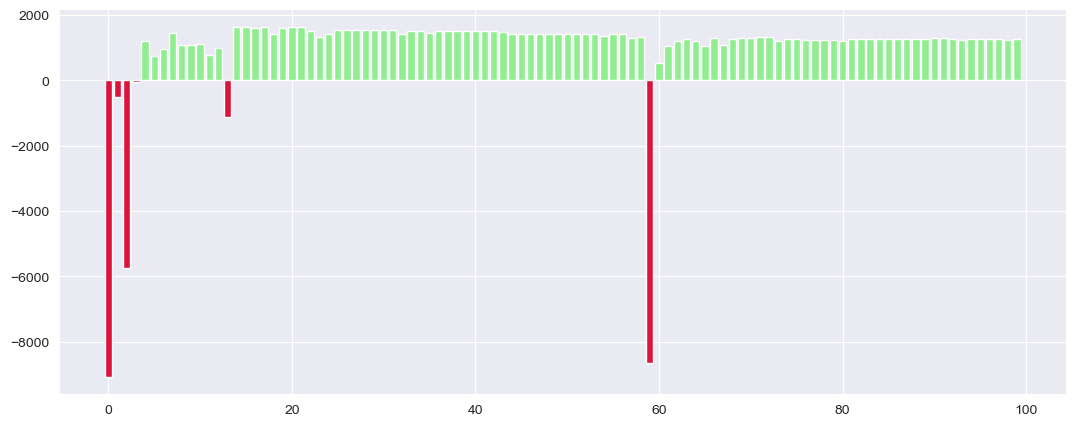

In [32]:
recent_df = df.head(100)

plt.bar(
    recent_df.index, recent_df["<CLOSE>"] - recent_df["<OPENINT>"],
    color=np.where(recent_df["<CLOSE>"] - recent_df["<OPENINT>"] < 0, 'crimson', 'lightgreen'))

### Cleaning data
Here first we only keep <CLOSE> and <DTYYYYMMDD> columns. Because we are only going to work with those columns.
Then we convert date column (DTYYYYMMDD) to date column.
After that, because we were told to just keep last five years data,so we remove data that are from before past five years and then we sort them.

In [4]:
df.drop(USELESS_COLUMN_NAMES, axis=1, inplace=True)

df['date'] = pd.to_datetime(df[DATE_COLUMN_NAME], format='%Y%m%d', errors='coerce')
df.drop(DATE_COLUMN_NAME, axis=1, inplace=True)

df.rename(columns={CLOSE_COLUMN_NAME: 'price'}, inplace=True)  # only renaming a column in order to be comfortable with

curr_date = datetime.now().date()
oldest_date = curr_date - relativedelta(years=5)
oldest_date_dt64 = np.datetime64(oldest_date)

df = df[df['date'] > oldest_date_dt64].copy()

df.sort_values(by='date', ascending=True, inplace=True, ignore_index=True)

df

,price,date
0,8297.0,2019-10-20
1,8336.0,2019-10-21
2,8649.0,2019-10-22
3,8535.0,2019-10-23
4,8507.0,2019-10-26
...,...,...
1090,11850.0,2024-10-08
1091,11820.0,2024-10-09
1092,11470.0,2024-10-12
1093,11200.0,2024-10-13


#### statistical view

<Axes: >

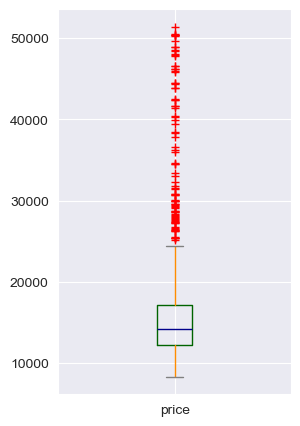

In [28]:
color = {
    "boxes": "DarkGreen",
    "whiskers": "DarkOrange",
    "medians": "DarkBlue",
    "caps": "Gray",
}
df.plot.box(color=color, sym="r+", figsize=(3, 5)

In [5]:
df.groupby(df.date.dt.year).mean()

,price,date
date,,
2019,9763.456522,2019-11-24 22:57:23.478260992
2020,24797.215247,2020-07-01 04:11:50.313901312
2021,16265.947137,2021-06-29 05:42:33.303964672
2022,15164.497354,2022-06-10 07:14:17.142857216
2023,12912.391304,2023-07-03 12:06:15.652173824
2024,11465.888889,2024-05-21 04:40:00.000000000


#### data view

In [33]:
df

,<TICKER>,<DTYYYYMMDD>,<FIRST>,<HIGH>,<LOW>,<CLOSE>,<VALUE>,<VOL>,<OPENINT>,<PER>,<OPEN>,<LAST>
0,MAPNA,20070826,1350.0,1359.0,1350.0,1352.0,591427151280,437402390,10429,D,1350.0,1352.0
1,MAPNA,20070827,1379.0,1379.0,1379.0,1379.0,19347625115,14030185,1887,D,1352.0,1379.0
2,MAPNA,20070828,1406.0,1406.0,1370.0,1403.0,144131253978,102663438,7137,D,1379.0,1403.0
3,MAPNA,20070901,1420.0,1431.0,1407.0,1429.0,26814720068,18758591,1468,D,1403.0,1429.0
4,MAPNA,20070902,1457.0,1457.0,1457.0,1457.0,4749522772,3259796,241,D,1429.0,1457.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3426,MAPNA,20241008,11750.0,11750.0,11750.0,11850.0,14253455000,1213060,62,D,11860.0,11750.0
3427,MAPNA,20241009,11740.0,11740.0,11740.0,11820.0,30183246500,2570975,81,D,11850.0,11740.0
3428,MAPNA,20241012,11470.0,11630.0,11470.0,11470.0,760995635740,66344622,2136,D,11820.0,11470.0
3429,MAPNA,20241013,11290.0,11560.0,11130.0,11200.0,175534736600,15671221,1068,D,11470.0,11130.0


(array([17897., 18262., 18628., 18993., 19358., 19723., 20089.]),
 [Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023'),
  Text(19723.0, 0, '2024'),
  Text(20089.0, 0, '2025')])

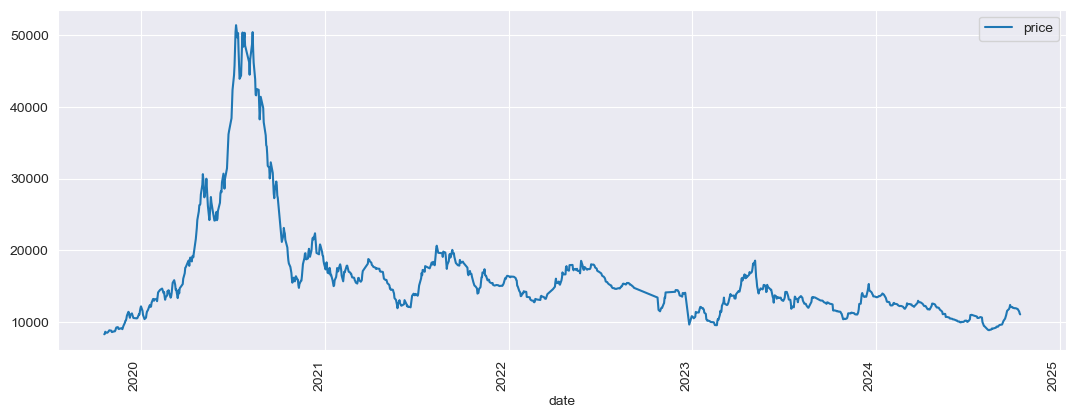

In [25]:
df

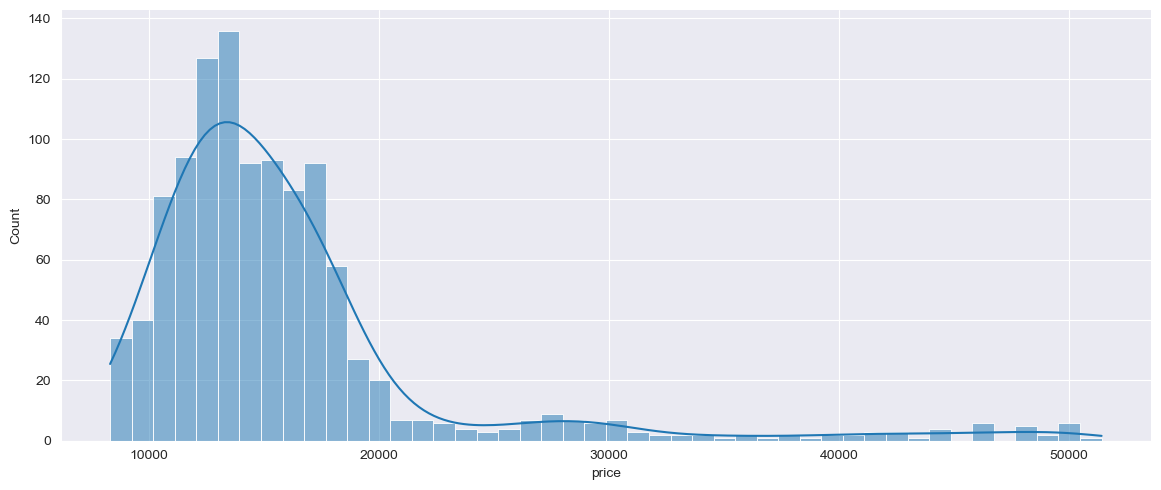

In [26]:
sns.displot(df['price'], kde=True).fig.set_size_inches(13, 5)

<Axes: xlabel='date', ylabel='price'>

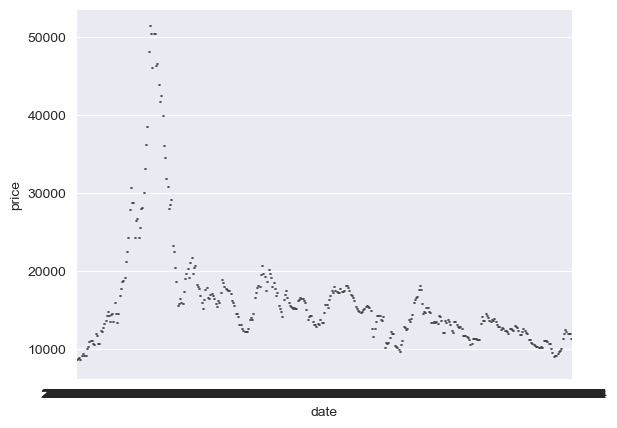

In [10]:
sns.violinplot(x='date', y='price', data=df)

In [27]:
df.groupby(df.date.dt.year)